In [ ]:
import os
import sys

# Set paths
sys.path.extend([
    os.path.abspath(os.path.join("../..")),
    os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/"))
])


import datetime
from functools import partial

import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from network import configure_input
from helpers import custom_plot_sbc_ecdf, custom_plot_mmd_hypothesis_test
from simulation import setup_simulator

In [2]:
from matplotlib import rcParams

In [3]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator, ContextGenerator
from bayesflow.trainers import Trainer
from bayesflow.computational_utilities import maximum_mean_discrepancy

## Defining the Generative Model

Our underlying model distinguishes between susceptible, $S$, infected, $I$, and recovered, $R$, individuals with infection and recovery occurring at a constant transmission rate $\lambda$ and constant recovery rate $\mu$, respectively. The model dynamics are governed by the following system of ODEs:

$$
\begin{align}
    \frac{dS}{dt} &= -\lambda\,\left(\frac{S\,I}{N}\right) \\
    \frac{dI}{dt} &= \lambda\,\left(\frac{S\,I}{N}\right) - \mu\,I \\
    \frac{dR}{dt} &= \mu\,I,
\end{align}
$$

with $N = S + I + R$ denoting the total population size. For the purpose of forward inference (simulation), we will use a time step of $dt = 1$, corresponding to daily case reports. In addition to the ODE parameters $\lambda$ and $\mu$, we consider a reporting delay parameter $L$ and a dispersion parameter $\psi$, which affect the number of reported infected individuals via a negative binomial distribution (https://en.wikipedia.org/wiki/Negative_binomial_distribution). 

Let's first define a global singleton for accessing the `numpy` random number generator:

In [4]:
RNG = np.random.default_rng(2023)

### Prior

Our prior has a new argument called `alpha`. What this argument does is to scale each marginal prior $j$ in the following way $p(\theta_j) \rightarrow p(\theta_j)^{\alpha_j}$.

The above transformation is called power scaling and is descrtibed in more detail in the paper by Noa Kallioinen, Topi Paananen, Paul-Christian Bürkner, and Aki Vehtari:

<em>Detecting and diagnosing prior and likelihood sensitivity with power-scaling</em> (https://arxiv.org/abs/2107.14054)

Essentially, the power scaling method expands or shrinks the prior pdf, thus assuming a sort of <strong>hierarchical prior</strong> with adaptive sharpness. However, differently to hierarchical Bayesian models, we will not estimate the hyperparameter $\alpha$, but probe our results with different values of $\alpha$ in some meaningful range (here $\alpha \in [0.5 - 2]$).
The neat trick is this: we will perform <strong>amortized prior sensitivity analysis</strong>. Instead of training one `AmortizedPosterior`, we will include $\alpha$ in the generative process and treat it as a context variable over which to amortize. This means, that the scaling factors will simply be concatenated with the outputs of the summary network and passed on to the inference network. In this way, upon convergence, we end up with an $\alpha$-aware inference network, which can yield a posterior for each $\alpha$ we supply during inference.

#### Context Generator Function


During training, we will generate the scaling parameters from a continuous uniform distribution:

$$
\alpha_j \sim \exp(\mathcal{U}(\log(0.5), \log(2.0)))
$$

In this way, the inference network will see both simulations with a narrower prior ($\alpha > 1$) and a wider prior ($\alpha < 1$) than our original prior choice ($\alpha = 1$). We sample the scaling factors in log space to ensure equal amounts of widening and shrinking. 

In [5]:
from simulation import alpha_gen

#### Prior Generator Function

We can now also define the function which will generate random draws from the prior. Notice the additional argument specifying the vector of $\alpha$-scaling parameters. Note also, that scaling different pdfs has different effect on the corresponding parameters. For instance, performing power scaling on an [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) pdf simply means dividing it's shape parameters by $\alpha$. Further examples are given in https://arxiv.org/abs/2107.14054.

In [6]:
from simulation import model_prior

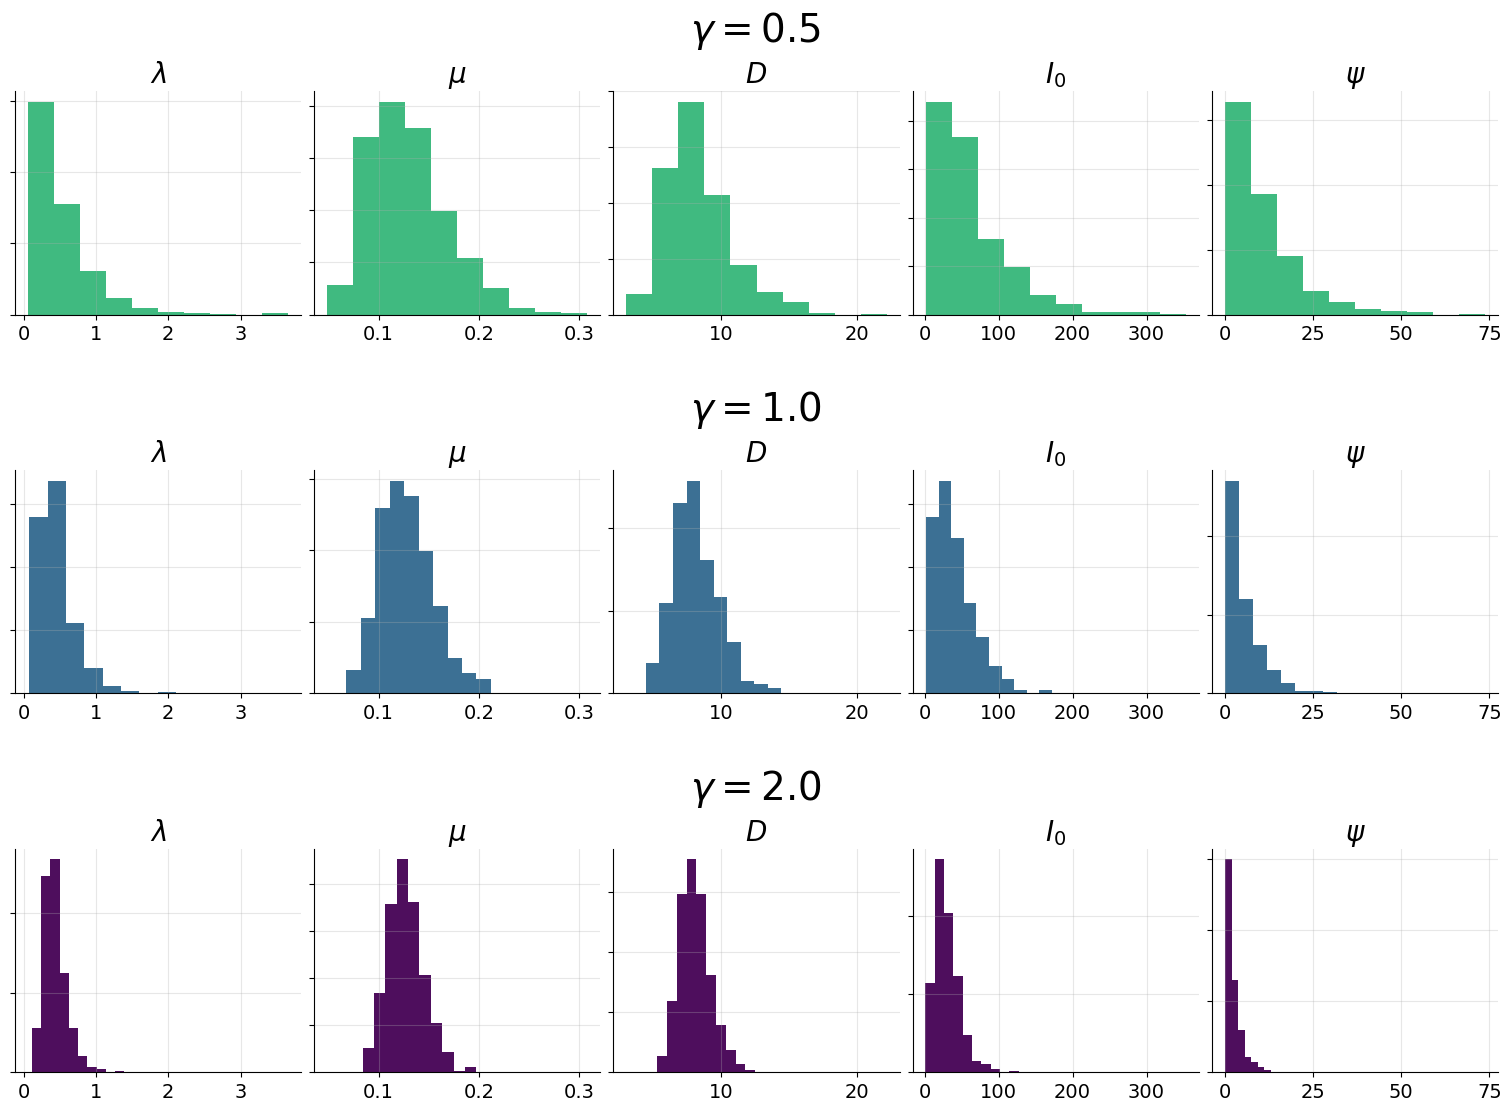

In [7]:
# Plot prior predictives
param_names = [r"$\lambda$", r"$\mu$", r"$D$", r"$I_0$", r"$\psi$"]
color_codes = {
    r"$\alpha = 0.5$": '#35b779',
    r"$\alpha = 1.0$": '#31688e',
    r"$\alpha = 2.0$": '#440154'
}

num_samples = 1000
alpha_values = [0.5, 1.0, 2.0]

fig = plt.figure(constrained_layout=True, figsize=(15, 11))
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.1)
all_axes = []  # hack to enable shared x axis lims per column

for i, alpha in enumerate(alpha_values):

    axes = subfigs[i].subplots(nrows=1, ncols=5)
    all_axes.append(axes)
    subfigs[i].suptitle(r'$\gamma = {}$'.format(alpha), fontsize=28)

    for j, param_name in enumerate(param_names):
        alphas = np.repeat(alpha, 5)
        data = np.array([model_prior(alphas) for _ in range(num_samples)])

        ax = axes[j]
        ax.grid(alpha=0.3)
        ax.hist(data[:, j], density=True, alpha=0.95, color=list(color_codes.values())[i])
        ax.set_title(param_name, fontsize=20)
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis="both", which="major", labelsize=14)

        if i > 0:
            ax.set_xlim(all_axes[0][j].get_xlim())

        sns.despine()

#fig.savefig('../../figures/covid_prior_under_scaling.pdf', dpi=300, bbox_inches='tight')

Great! We can now connect the context generating function with the prior sampler using `BayesFlow` wrappers:

In [8]:
prior_context = ContextGenerator(batchable_context_fun=alpha_gen)
prior = Prior(prior_fun=model_prior, context_generator=prior_context)

When we now call the `Prior` object, we can see that the entry `batchable_context` in the output dictionary is filled with the scaling parameters used to generate each random draw. The context is dubbed <em>batchable</em>, because for each random draw from the prior in a batch of simulations, there is a corresponding context variable. In contrast, a `non_batchable_context` would be shared across all simulated quantities within a batch.

Notice, that the context variables are returned as a `list` type. This is done in order to deal with cases where the context variables cannot be coerced to a rectangular array or tensor. Our `configurator` should take care of this!

In [9]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=1000000)

### Simulator (Implicit Likelihood Function)

Our simulator remains unchanged:

In [10]:
from simulation import stationary_SIR

### Loading Real Data

We will define a simple helper function to load the actually reported cases for the first 2 weeks in Germany.

In [11]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

Again, we can collect the simulator settings, together with the observed data, into a dictionary:

In [12]:
config = {"T": 14, "N": 83e6, "obs_data": load_data()}

And we now define our simulator as before, using fixed $T$ and $N$. You already guessed this, that varying this variables will amount to nothing different than further context variables...

In [13]:
simulator = Simulator(simulator_fun=partial(stationary_SIR, T=config["T"], N=config["N"]))

### Generative Model

In [14]:
model = GenerativeModel(prior, simulator, name="alpha_covid_simulator")

INFO:root:Performing 2 pilot runs with the alpha_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 14, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:Could not determine shape of prior batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Defining the Amortizer and Trainer

We can always do a quick check that our configurator works well with the outputs of the generative model:

In [15]:
_ = configure_input(model(batch_size=2), prior_means, prior_stds)

In [16]:
from network import setup_network

CHECKPOINT_PATH = "checkpoints/single_nets/powerscaled"

amortizer, trainer = setup_network(
    generative_model=model, 
    checkpoint_path=CHECKPOINT_PATH,
    prior_means=prior_means,
    prior_stds=prior_stds,
    is_fix_alpha=False
)

INFO:root:Loaded loss history from checkpoints/single_nets/powerscaled\history_75.pkl.
INFO:root:Networks loaded from checkpoints/single_nets/powerscaled\ckpt-75


## Data

In [17]:
offline_data = model(2**14)
val_data = model(500)

## Training Phase

In [18]:
if not os.path.exists(CHECKPOINT_PATH): # Only train when no checkpoints exist
    with tf.device('/cpu:0'): # Faster for these small networks
        h = trainer.train_offline(offline_data, epochs=75, batch_size=32, validation_sims=val_data)

## Validation

In [19]:
param_names = [r"$\lambda$", r"$\mu$", r"$D$", r"$I_0$", r"$\psi$"]
h = trainer.loss_history.get_plottable()

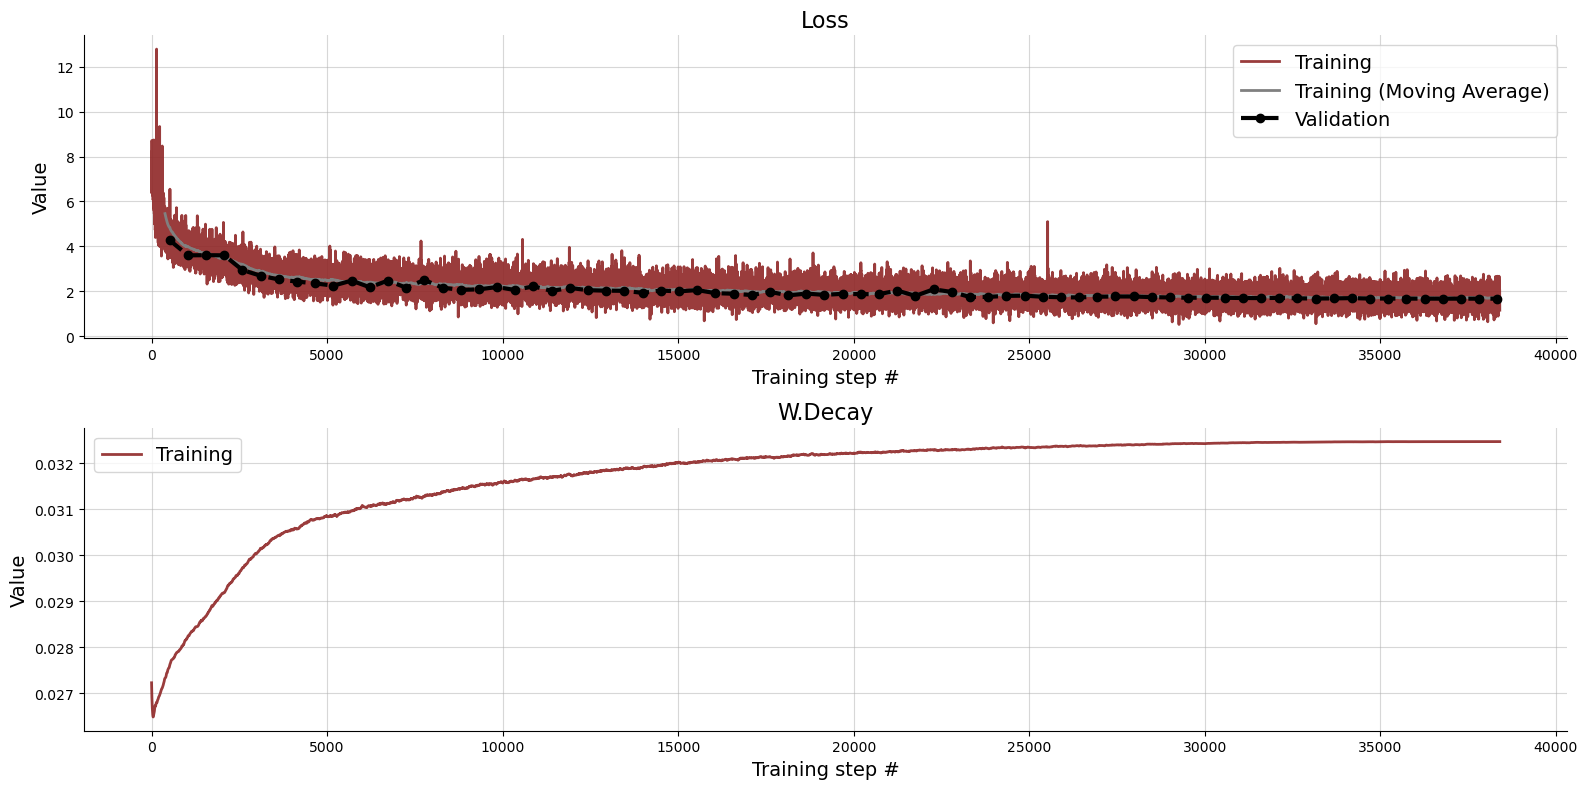

In [20]:
f = diag.plot_losses(h['train_losses'], h['val_losses'], moving_average=True)

In [ ]:
# Generate test data if not already exists
if not os.path.exists("simulations"): # Only execute when no folder exists yet
    for alpha in alpha_values:
        alpha_str = str(alpha)[0] + str(alpha)[-1] # use some funny stuff to adapt to old naming convention
        prior, simulator, model = setup_simulator(config=config, fix_alpha=alpha)
        sim_data = model(1000)
        pickle.dump(sim_data, open(f'simulations/sims_{alpha_str}.pkl', 'wb+'))

In [21]:
# Load test simulations
conf_05 = configure_input(pickle.load(open('simulations/sims_05.pkl', 'rb+')), prior_means, prior_stds)
conf_10 = configure_input(pickle.load(open('simulations/sims_10.pkl', 'rb+')), prior_means, prior_stds)
conf_20 = configure_input(pickle.load(open('simulations/sims_20.pkl', 'rb+')), prior_means, prior_stds)

# Get posterior draws
draws_05 = amortizer.sample(conf_05, n_samples=250)
draws_10 = amortizer.sample(conf_10, n_samples=250)
draws_20 = amortizer.sample(conf_20, n_samples=250)

# Publication plots

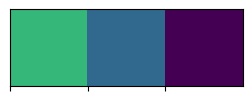

In [22]:
color_codes = {
    r"$\alpha = 0.5$": '#35b779',
    r"$\alpha = 1.0$": '#31688e',
    r"$\alpha = 2.0$": '#440154'
}
sns.palplot(color_codes.values())

In [23]:
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatino']

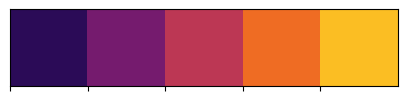

In [24]:
import matplotlib.colors as mcolors
color_codes_marginal = [mcolors.rgb2hex(plt.get_cmap("inferno")(i)) for i in np.linspace(0.15, 0.85, 5)]

sns.palplot(color_codes_marginal)

## SBC (Closed World)

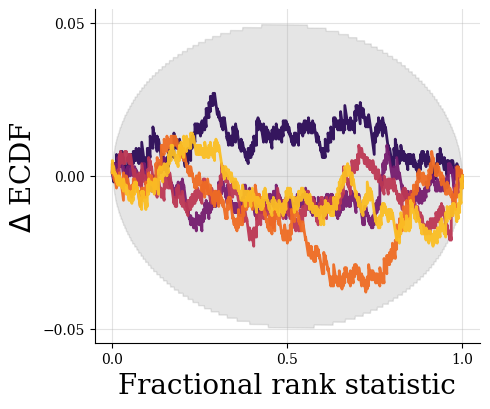

In [32]:
# Marginal calibration over the full C_P space
conf_marginal = configure_input(model(1000), prior_means, prior_stds)
draws_marginal = amortizer.sample(conf_marginal, n_samples=250) 

f, ax = plt.subplots(1, 1, figsize=(5, 4.2))
custom_plot_sbc_ecdf(
    draws_marginal, 
    conf_marginal['parameters'], 
    ax=ax, 
    rank_ecdf_color=color_codes_marginal, 
    difference=True,
    stacked=True
    )
sns.despine(ax=ax)
ax.grid(alpha=0.35)
ax.set_xticks(np.linspace(0, 1, 3))
ax.set_xlabel("Fractional rank statistic", fontsize=20)
ax.set_yticks(np.linspace(-0.05, 0.05, 3))
ax.set_ylabel(r'$\Delta$ ECDF', fontsize=20)
f.tight_layout()

In [33]:
f.savefig('../../figures/covid_marginal_calibration.pdf', dpi=300, bbox_inches='tight')

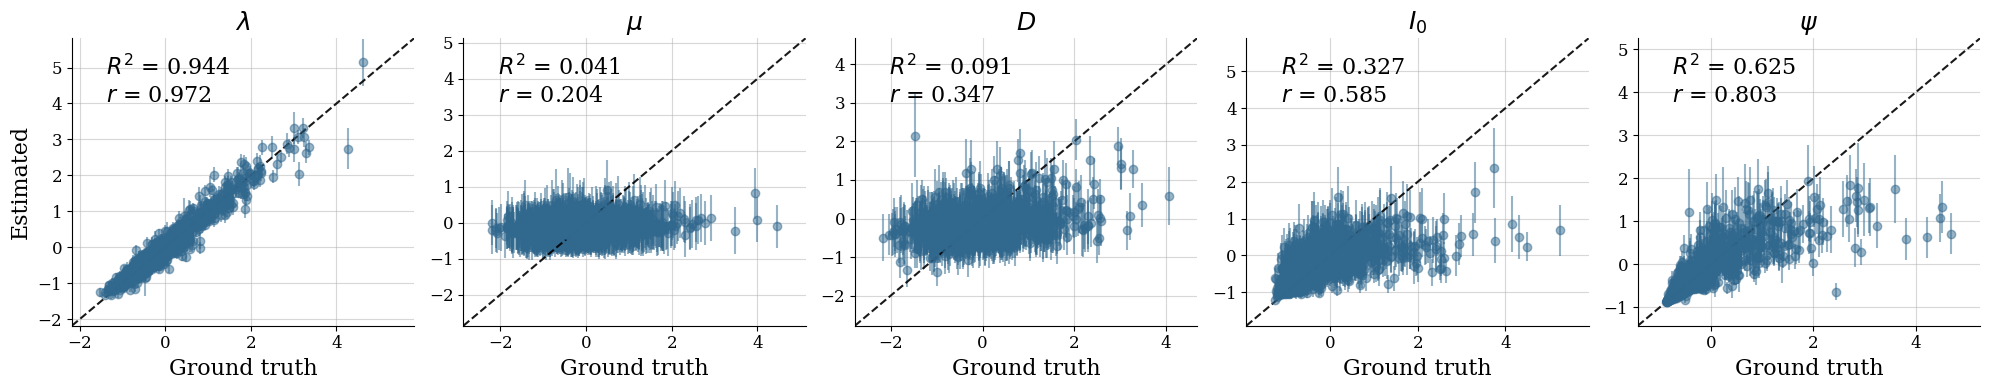

In [24]:
f = diag.plot_recovery(draws_10, conf_10["parameters"], param_names=param_names, color=color_codes[r"$\alpha = 1.0$"], )

In [25]:
f.savefig('../../figures/covid_recovery.pdf', dpi=300, bbox_inches='tight')

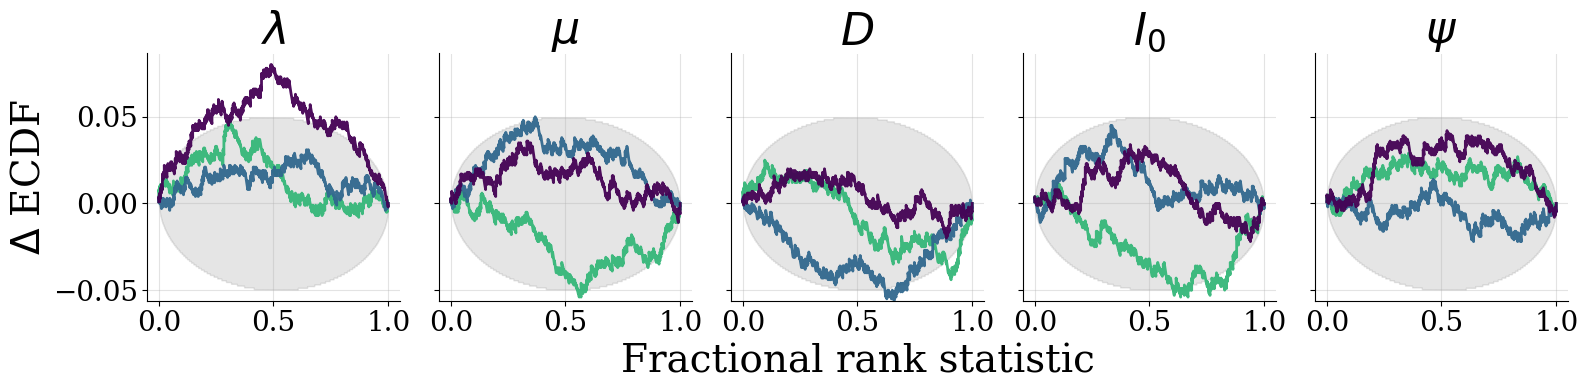

In [26]:
f, ax = plt.subplots(1, 5, figsize=(16, 4))
custom_plot_sbc_ecdf(draws_05, conf_05['parameters'], ax=ax, rank_ecdf_color=color_codes[r"$\alpha = 0.5$"], 
                     difference=True)
custom_plot_sbc_ecdf(draws_10, conf_10['parameters'], ax=ax, rank_ecdf_color=color_codes[r"$\alpha = 1.0$"], 
                     difference=True, add_bounds=False)
custom_plot_sbc_ecdf(draws_20, conf_20['parameters'], ax=ax, rank_ecdf_color=color_codes[r"$\alpha = 2.0$"], 
                     difference=True, add_bounds=False)

# Prettify plot
for i, _ax in enumerate(ax):
    sns.despine(ax=_ax)
    _ax.grid(alpha=0.35)
    _ax.set_title(param_names[i], fontsize=32)
    _ax.tick_params(axis="both", which="major", labelsize=20)
    _ax.tick_params(axis="both", which="minor", labelsize=20)
    _ax.set_xlabel("")
    _ax.set_xticks(np.linspace(0, 1, 3))
    if i > 0:
        _ax.set_ylim(ax[0].get_ylim())
        _ax.set_yticklabels([])

ax[2].set_xlabel("Fractional rank statistic", fontsize=28)
ax[0].set_ylabel(r'$\Delta$ ECDF', fontsize=28)
f.tight_layout()

In [27]:
f.savefig('../../figures/covid_ecdfs.pdf', dpi=300, bbox_inches='tight')

## Real Data

In [36]:
samples_alpha = []
for alpha in [0.5, 1, 2]:
    samples = amortizer.sample(
        {
            "summary_conditions": np.log1p(config['obs_data']).astype(np.float32)[np.newaxis, :, np.newaxis],
            "direct_conditions": alpha * np.ones((1, 5)).astype(np.float32),
        },
        n_samples=10000,
        to_numpy=True,
    )
    samples = pd.DataFrame(prior_stds*samples + prior_means, columns=param_names)
    samples_alpha.append(samples)

df_all = pd.concat(samples_alpha, axis=0)

df_all["Scaling factor"] = (
    [r"$\alpha = 0.5$"] * len(samples_alpha[0])
    + [r"$\alpha = 1.0$"] * len(samples_alpha[1])
    + [r"$\alpha = 2.0$"] * len(samples_alpha[2])
)

### MMD between parameter posteriors

In [45]:
# 0.5 vs 1
with tf.device('/cpu:0'):
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=np.array(samples_alpha[0]), reference_data=np.array(samples_alpha[1]), num_null_samples=100, bootstrap=True
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
# 2 vs 1 (we only need 2 as we already have the sampling distribution for 1)
with tf.device('/cpu:0'):
    MMD_observed_alpha2 = np.sqrt(maximum_mean_discrepancy(
        source_samples = tf.convert_to_tensor(samples_alpha[1], dtype=tf.float32), 
        target_samples = tf.convert_to_tensor(samples_alpha[2], dtype=tf.float32)
    ))

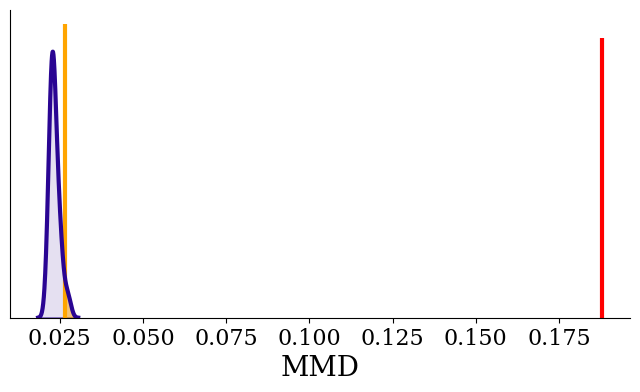

In [47]:
f = custom_plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
f.savefig('../../figures/covid_MMD_0.5vs1.pdf', dpi=300, bbox_inches='tight')

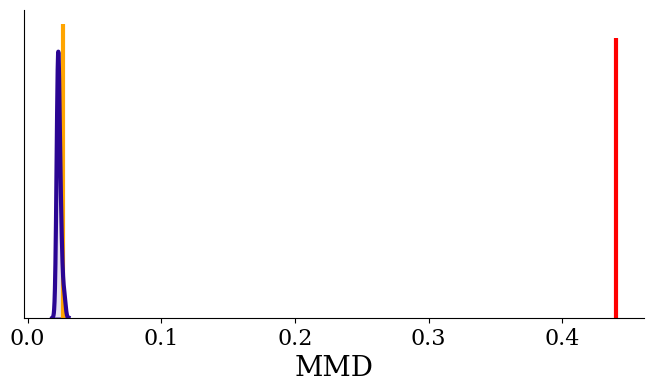

In [48]:
f = custom_plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed_alpha2)
f.savefig('../../figures/covid_MMD_2vs1.pdf', dpi=300, bbox_inches='tight')

### Plot two Posteriors

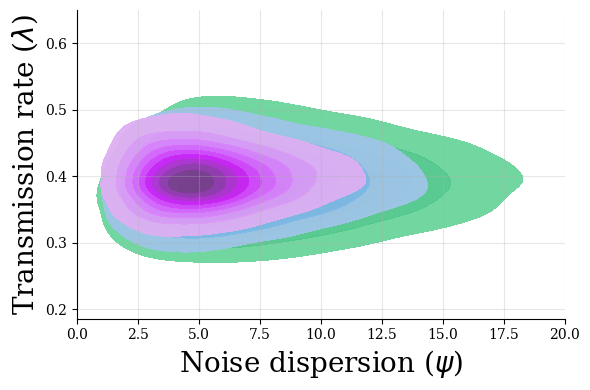

In [43]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.kdeplot(y='$\lambda$', x='$\psi$', data=samples_alpha[0], 
            fill=True, 
            alpha=0.95, 
            bw_adjust=1.5,
            color=color_codes[r"$\alpha = 0.5$"], label=r"$\alpha = 0.5$",
            ax=ax)

sns.kdeplot(y='$\lambda$', x='$\psi$', data=samples_alpha[1], 
            fill=True, 
            alpha=0.95,
            ax=ax,
            bw_adjust=1.5,
            color=color_codes[r"$\alpha = 1.0$"], label=r"$\alpha = 1.0$")


sns.kdeplot(y='$\lambda$', x='$\psi$', data=samples_alpha[2], 
            fill=True, 
            alpha=0.95, 
            ax=ax,
            bw_adjust=1.5,
            color=color_codes[r"$\alpha = 2.0$"], label=r"$\alpha = 2.0$")
sns.despine(ax=ax)
ax.set_xlim([0, 20])
ax.set_xlabel(r'Noise dispersion ($\psi$)', fontsize=20)
ax.set_ylabel(r'Transmission rate ($\lambda$)', fontsize=20)
ax.grid(alpha=0.3)
f.tight_layout()

In [44]:
f.savefig('../../figures/covid_pairs.pdf', dpi=300, bbox_inches='tight')

### Predictions

In [40]:
def plot_ppc(config, post_samples, ax, logscale=False, color="#8f2727", font_size=18, plot_obs=False):
    """
    Helper function to perform some plotting of the posterior predictive.
    """

    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    print('Used samples: ', samples.shape[0])

    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim
        sim_cases = stationary_SIR(samples[i], config["N"], config["T"])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)

    # Compute quantiles for each t = 1,...,T
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)

    if plot_obs:
        ax.plot(config["obs_data"], 
                marker="o", label="Reported cases", color="black", linestyle="dashed", alpha=0.9)

    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config["T"]), qs_90[0], qs_90[1], color=color, alpha=0.65)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), color=color)

    if logscale:
        ax.set_yscale("log")

Used samples:  10000
Used samples:  10000
Used samples:  9999


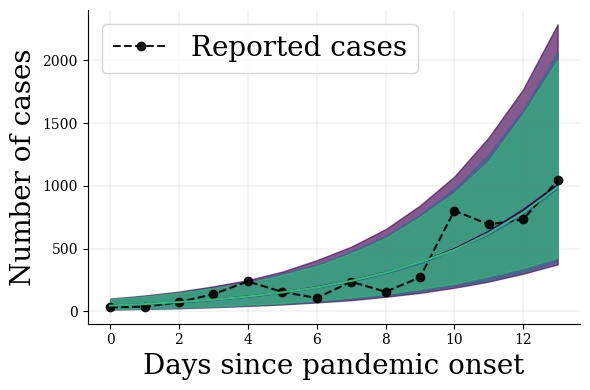

In [41]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))


plot_ppc(config, samples_alpha[2].values, ax=ax, color=color_codes[r"$\alpha = 2.0$"])
plot_ppc(config, samples_alpha[1].values, ax=ax, color=color_codes[r"$\alpha = 1.0$"])
plot_ppc(config, samples_alpha[0].values, ax=ax, color=color_codes[r"$\alpha = 0.5$"], plot_obs=True)


# Grid and schmuck
ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Days since pandemic onset", fontsize=20)
ax.set_ylabel("Number of cases", fontsize=20)
ax.legend(fontsize=20, loc='upper left')
ax.minorticks_off()
f.tight_layout()

In [42]:
f.savefig('../../figures/covid_preds.pdf', dpi=300, bbox_inches='tight')